# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

## Общая информация о данных

In [1]:
# Подключим необходимые библиотеки

from pymystem3 import Mystem
m = Mystem()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats as st

In [2]:
data = pd.read_csv("/datasets/games.csv", sep=",")

print(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [3]:
print('Количество дубликатов в данных:', data.duplicated().sum())

Количество дубликатов в данных: 0


Датасет содержит **11 столбцов и 16715 строк**. Имеющиеся типы данных - **float** и **object**. Заметно, что имеются по два пропуска в столбцах `Name` и `Genre`, а также около 270 пропусков в столбце `Year_of_Release`. Много пропусков имеют столбцы `Critic_Score`, `User_Score`, `Rating`. Явных дубликатов в данных нет.

## Преодбработка данных

### Обработка столбцов

Для удобства работы с данными для начала приведем названия всех столбцов к нижнему регистру:

In [4]:
data.columns = [x.lower() for x in data.columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Замена типа данных необходима в столбце `year_of_release`, т.к. это год выпуска - он должен быть целым числом.

In [5]:
data['year_of_release'] = data['year_of_release'].astype('Int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


### Обработка пропусков

Посмотрим точное количество пропусков в данных:

In [6]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [7]:
data.query('name.isna()') # Проверим, находятся ли два пропуска в `genre` в тех же строках, что и пропуски `name`

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Эти две игры действительно имеют пропуск и в `name` и в `genre`, более того, отсутствуют данные об оценках. Эти две строки можно убрать из датафрейма (2 шт. очень мало против остальных 16,5 тысяч строк, на исследование не повлияет).

In [8]:
data.dropna(subset=['name'], inplace=True)
data.reset_index(inplace=True,drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


Пропуски в остальных столбцах не стоит заполнять и сами строки не следует удалять - это исказит результаты корреляционного анализа и стат-тестов.

In [9]:
# Изучим столбец `user_score` подробнее

display(data[['user_score']].describe())
display(data['user_score'].value_counts())

,user_score
count,10014
unique,96
top,tbd
freq,2424


tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1         2
0.7       2
1.3       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

In [10]:
display(data[data['user_score']=="tbd"])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16693,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16695,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16696,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16702,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Имеется 2424 строки с записью **tbd** в столбце с оценкой пользователей. "tbd" - аббревиатура "to be determined", что значит "будет определено". Эту запись имеют игры с совершенно разными годами выпуска, а не только вышедшие в 2016. По каким-то причинам эти игры не были оценены пользователями. Так как оценки нет, можно лишь поменять запись *tbd* на NaN.

In [11]:
data.loc[data['user_score']=="tbd", 'user_score']=np.nan 

# Также заменим тип данных столбца на float, т.к. теперь в нем только числа
data['user_score'] = data['user_score'].astype('float') 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


Посчитаем суммарные продажи во всех регионах и добавим их в отдельный столбец.

In [12]:
data['sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Пропуски в столбцах с оценками критиков и пользователей могли появиться по причине того, что игра просто не была оценена, либо же в источнике, откуда брались эти данные, не было этой информации. Пропуски в столбце `rating` могут быть потому, что организация ESRB выдает рейтинги для игр, вышедших для рынка США и Канады, а если игра не претендует на этот рынок, то и рейтинг ESRB ей не нужен (например, игра для Японского рынка).

## Исследовательский анализ данных

### Количество выпущенных игр по годам

In [13]:
# Создадим сводную таблицу с количеством релизов в год

releases = data.groupby('year_of_release')['name'].count().reset_index()
releases.columns = ['year', 'count']
releases

,year,count
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


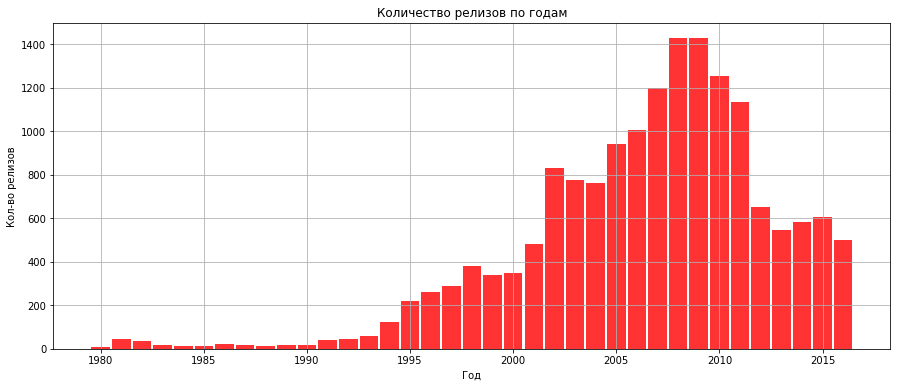

In [14]:
plt.figure(figsize=(15, 6))
plt.bar(releases['year'], releases['count'], label='Кол-во релизов за год', color='red', alpha=0.8, width=0.9)
plt.xlabel('Год')
plt.ylabel('Кол-во релизов')
plt.title('Количество релизов по годам')
plt.grid()
plt.show()

По графику можно сделать вывод, что резкий рост количества выпущенных игр начался после 1995 года, компьютерные технологии развивались, и следующие 15 лет (до 2010) выходило очень много игр. Затем, к 2016 году количество упало в два раза и держится примерно на одном уровне.

### Анализ продаж по платформам

In [15]:
# Создадим сводную таблицу с продажами по платформам

sales = data.groupby('platform')['sales'].sum().sort_values().reset_index()
sales

,platform,sales
0,PCFX,0.03
1,GG,0.04
2,3DO,0.10
3,TG16,0.16
4,WS,1.42
5,NG,1.44
6,SCD,1.86
7,DC,15.95
8,GEN,28.35
9,SAT,33.59


Отберем топ-10 платформ по суммарным продажам:

In [16]:
top_platforms = sales.loc[20:30, 'platform'].values
top_platforms

array(['3DS', 'PC', 'PSP', 'PS4', 'GBA', 'PS', 'DS', 'Wii', 'PS3', 'X360',
       'PS2'], dtype=object)

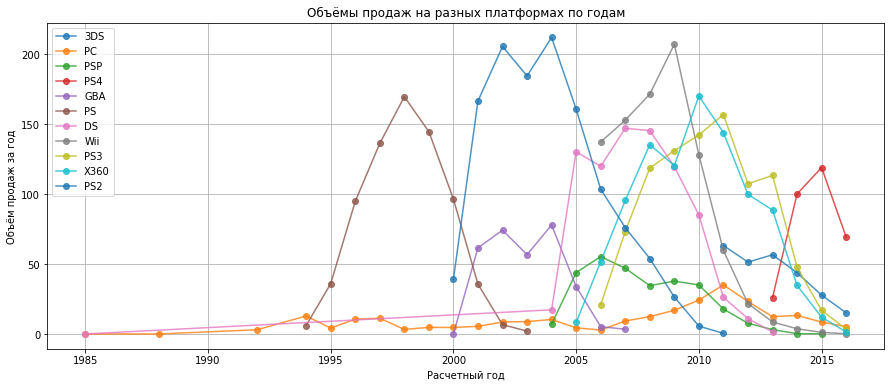

In [17]:
plt.figure(figsize=(15, 6))
plt.title('Объёмы продаж на разных платформах по годам')

mean_year_life = 0
for i in range(0,len(top_platforms)):
    platform  = data.query('platform == @top_platforms[@i]').groupby('year_of_release')['sales'].sum()
    mean_year_life += platform.count()
    platform.plot(x=platform.index, y=platform.values, style='-o', label=top_platforms[i], alpha=0.8, grid=True)
    
plt.xlabel('Расчетный год')    
plt.ylabel('Объём продаж за год')
plt.legend()
plt.show()

In [18]:
print('Срок службы платформы: около', round(mean_year_life/len(top_platforms), 2), 'лет')

Срок службы платформы: около 11.18 лет


Расчетное значение срока "жизни" платформы - **около 11 лет**. По графику видна такая же закономерность для большинства платформ, если не брать в расчет PC (ПК), т.к. игры на него выходили и будут выходить всегда. С DS (Nintendo DS) какая-то ошибка, т.к. интернет говорит о том, что первая игра на этой платформе вышла как раз в 2004 году, а не в 1985.

### Прогноз на 2017 год

Из предыдущего пункта мы выяснили, что срок жизни платформы - 11 лет. Исходя из этого, возьмем данные за *актуальный период* - последние 11 лет, то есть с 2005 по 2016 год. 

In [19]:
# Создадим сводную таблицу с играми, выпущенными в период 2005-2016 гг.; посчитаем продажи на каждой платформе

data2017 = data.pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='sum').\
    query('year_of_release>2004').fillna(0).reset_index()
data2017['year_of_release'] = data2017['year_of_release'].astype('Int64')

for column in data2017.columns:
    if data2017[column].sum()==0:
        data2017.drop(column, axis=1,inplace=True)

display(data2017)

platform,year_of_release,3DS,DC,DS,GBA,GC,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
0,2005,0.00,0.00,130.14,33.86,27.62,4.37,160.66,0.00,0.00,43.84,0.00,0.00,0.00,8.25,49.08,0.00
1,2006,0.00,0.00,119.81,5.28,11.26,2.85,103.42,20.96,0.00,55.32,0.00,137.15,0.00,51.62,10.04,0.00
2,2007,0.00,0.02,146.94,3.40,0.27,9.28,75.99,73.19,0.00,46.93,0.00,152.77,0.00,95.41,0.55,0.00
3,2008,0.00,0.04,145.31,0.00,0.00,12.42,53.90,118.52,0.00,34.55,0.00,171.32,0.00,135.26,0.18,0.00
4,2009,0.00,0.00,119.54,0.00,0.00,16.91,26.40,130.93,0.00,37.78,0.00,206.97,0.00,120.29,0.00,0.00
5,2010,0.00,0.00,85.02,0.00,0.00,24.28,5.64,142.17,0.00,35.04,0.00,127.95,0.00,170.03,0.00,0.00
6,2011,63.20,0.00,26.18,0.00,0.00,35.03,0.45,156.78,0.00,17.82,4.63,59.65,0.00,143.84,0.00,0.00
7,2012,51.36,0.00,11.01,0.00,0.00,23.22,0.00,107.36,0.00,7.69,16.19,21.71,17.56,99.74,0.00,0.00
8,2013,56.57,0.00,1.54,0.00,0.00,12.38,0.00,113.25,25.99,3.14,10.59,8.59,21.65,88.58,0.00,18.96
9,2014,43.76,0.00,0.00,0.00,0.00,13.28,0.00,47.76,100.00,0.24,11.90,3.75,22.03,34.74,0.00,54.07


,platform,sales
0,X360,961.24
1,PS3,931.34
2,Wii,891.18
3,DS,785.49
4,PS2,426.46
5,PS4,314.14
6,PSP,282.47
7,3DS,257.81
8,PC,167.79
9,XOne,159.32


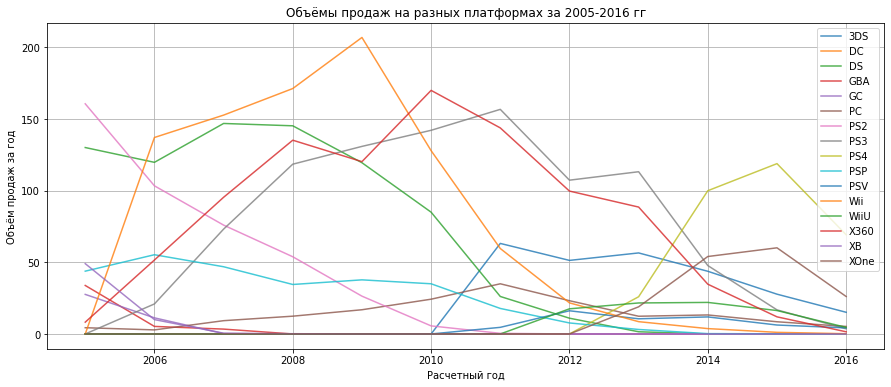

In [20]:
# Создадим таблицу с продажами по платформам начиная с 2005 года

top = data.query('year_of_release>=2005').groupby('platform')['sales'].sum().sort_values(ascending=False).reset_index()
display(top)

# Построим графики

plt.figure(figsize=(15, 6))
plt.title('Объёмы продаж на разных платформах за 2005-2016 гг')

i=0
for column in data2017.columns[1:]:
    plt.plot(data2017['year_of_release'].to_list(), data2017[column].to_list(), label=column, alpha=0.8);
    i+=1

plt.xlabel('Расчетный год')    
plt.ylabel('Объём продаж за год')
plt.legend()
plt.grid()
plt.show()

По графику определено следующее:

- Заметно, что некоторые популярные платформы (X360, PS3, Wii, DS) - уже были на пике своего развития и сейчас находятся в конце своего "времени жизни" (11 лет). Вкладываться в их развитие уже не стоит, так же как и в те платформы, котрые в принципе не сыскали популярности за последние 11 лет.


- Сильно выделяются две молодые платформы: PS4 и XOne, которые завоевали потребителя в 2014-2015, а в 2016 у них замечен небольшой спад популярности. Они еще нескоро потеряют свою актуальность, поэтому будет логично воспользоваться спадом и развивать эти две платформы, на данный момент являющиеся наиболее перспективными.


- На графике можно заметить еще 2 относительно успешные платформы, цикл жизни которых пройден только наполовину: WiiU и 3DS. В эти платформы также стоит вкладываться, но умереннее, чем в PS4 и XOne.


- Платформа PC живёт очень долго и будет жить дальше, всегда найдет своих пользователей, поэтому в нее также стоит продолжать вкладываться.

### Глобальные продажи игр по платформам

Перед построением графиков выделим из таблицы `top` платформы с наибольшими продажами:

In [21]:
top = top.head(8)
top

,platform,sales
0,X360,961.24
1,PS3,931.34
2,Wii,891.18
3,DS,785.49
4,PS2,426.46
5,PS4,314.14
6,PSP,282.47
7,3DS,257.81


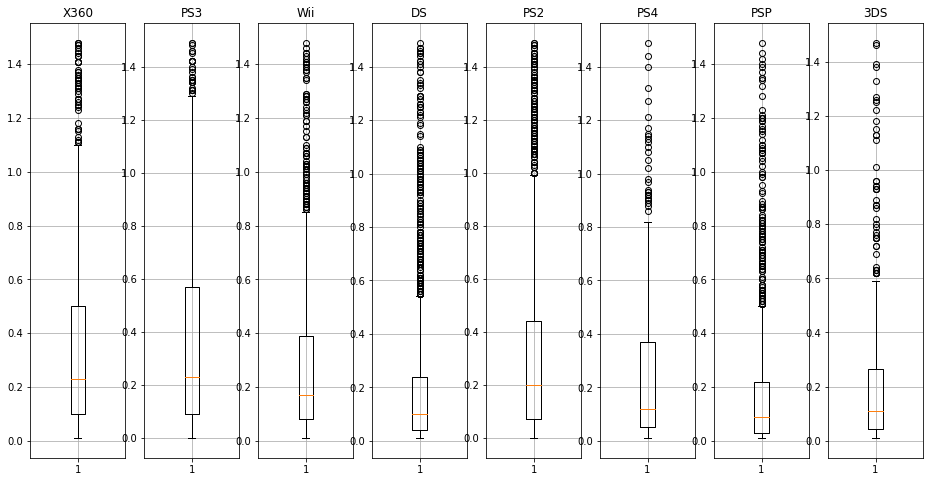

In [22]:
# Построим "ящики с усами" в разбивке по платформам

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=1, ncols=8, figsize=(16, 8))

p = {ax1:'X360', ax2:'PS3', ax3:'Wii', ax4:'DS', ax5:'PS2', ax6:'PS4', ax7:'PSP', ax8:'3DS'}
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    sales = data.query('platform==@p[@ax] and sales<1.5')['sales']
    ax.boxplot(sales)
    ax.grid()
    ax.set_title(p[ax])

Что можно вынести из графиков:

- Продажи на популярных платформах примерно схожи. Медианные значения продаж у четырех из них (X360, PS3, Wii, PS2) находятся близко к уровню **0,2 млн**.


- На остальных платформах медианы близки к уровню **0,1 млн**.


- На платформах X360 и PS3 продажи доходят до **1,1** и **1,3 млн** соответственно.

### Влияние отзывов пользователей и критиков на продажи внутри одной популярной платформы

Рассмотрим влияние отзывов на продажи на примере платформы PS3.

In [23]:
PS3 = data.query('platform=="PS3"')[['sales', 'critic_score', 'user_score']].dropna().reset_index(drop=True)
PS3.head()

,sales,critic_score,user_score
0,21.05,97.0,8.2
1,13.79,83.0,5.3
2,13.33,88.0,3.2
3,12.63,88.0,6.4
4,10.70,84.0,7.5


In [24]:
PS3.corr()

,sales,critic_score,user_score
sales,1.000000,0.427875,0.143252
critic_score,0.427875,1.000000,0.629005
user_score,0.143252,0.629005,1.000000


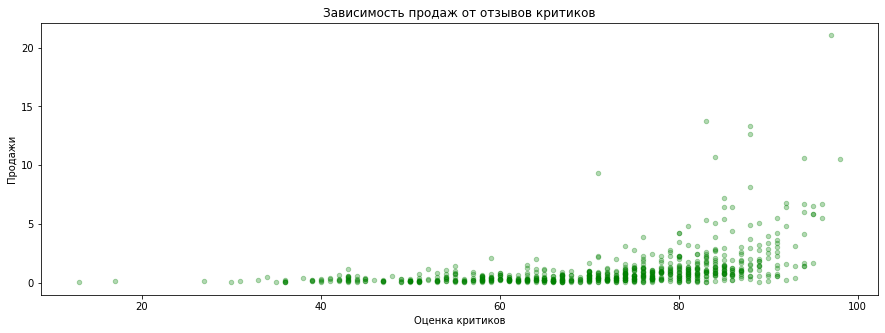

Коэффициент зависимости продаж от отзывов критиков = 0.42787500234912934


In [25]:
# Построим график зависимости продаж от отзывов критиков

PS3.plot(x='critic_score', y='sales', kind='scatter', figsize=(15,5), alpha=0.3, color = 'g')
plt.title('Зависимость продаж от отзывов критиков')
plt.xlabel('Оценка критиков')    
plt.ylabel('Продажи')
plt.show()

print('Коэффициент зависимости продаж от отзывов критиков =' , PS3['sales'].corr(PS3['critic_score']))

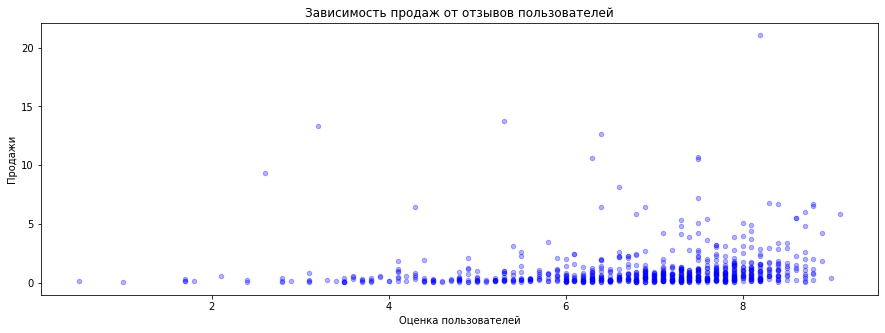

Коэффициент зависимости продаж от отзывов пользователей = 0.14325197544851784


In [26]:
# Построим график зависимости продаж от отзывов пользователей

PS3.plot(x='user_score', y='sales', kind='scatter', figsize=(15,5), alpha=0.3, color = 'b')
plt.title('Зависимость продаж от отзывов пользователей')
plt.xlabel('Оценка пользователей')    
plt.ylabel('Продажи')
plt.show()

print('Коэффициент зависимости продаж от отзывов пользователей =' , PS3['sales'].corr(PS3['user_score']))

Из графиков видно, что отзывы критиков сильнее влияют на продажи, чем отзывы пользователей (хотя само значение коэффициента зависимости от отзывов критиков не слишком высокое - **0,43**). Зависимость прямопропорцианальная - чем выше оценка, тем выше продажи. Характер распределения зависимости схож на обоих графиках.

**Соотнесём результат с другими платформами:**

In [27]:
# Создадим словарь с продажами и оценками

dict = {}
for platform in top['platform']:
    dict[platform] = data.query('platform==@platform')[['sales', 'critic_score', 'user_score']].dropna().reset_index(drop=True)

In [28]:
# Создадим таблицу корреляции продаж и отзывов по топ-платформам

i=0
corr = pd.DataFrame(columns=['platform','critic_sale','user_sale'])
for name in dict.keys():
    corr.loc[i, 'platform'] = name
    corr.loc[i, 'critic_sale'] = dict[name]['sales'].corr(dict[name]['critic_score'])
    corr.loc[i, 'user_sale'] = dict[name]['sales'].corr(dict[name]['user_score'])
    i+=1
    
corr

,platform,critic_sale,user_sale
0,X360,0.389513,0.110412
1,PS3,0.427875,0.143252
2,Wii,0.169668,0.110151
3,DS,0.230941,0.139453
4,PS2,0.38922,0.16942
5,PS4,0.405895,-0.033625
6,PSP,0.297313,0.230673
7,3DS,0.339824,0.233403


Отобразим зависимости на графиках:

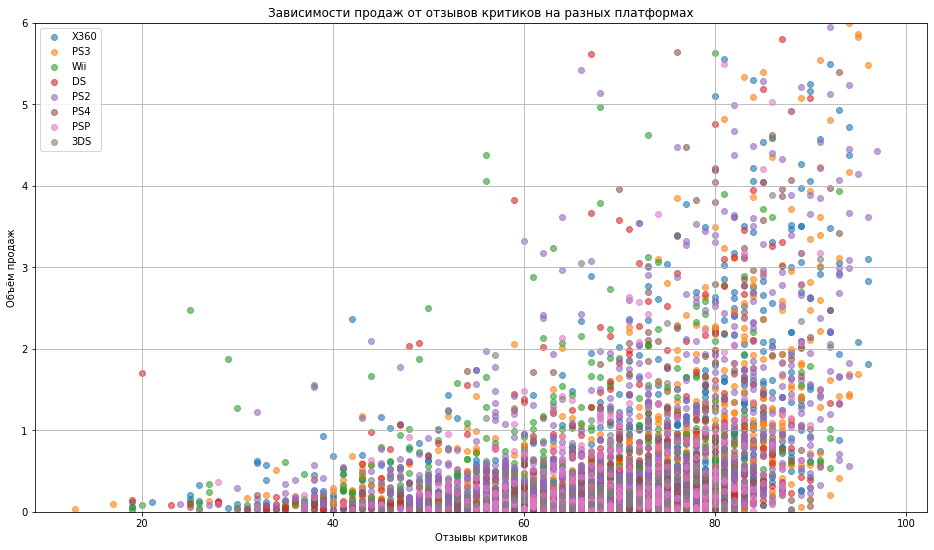

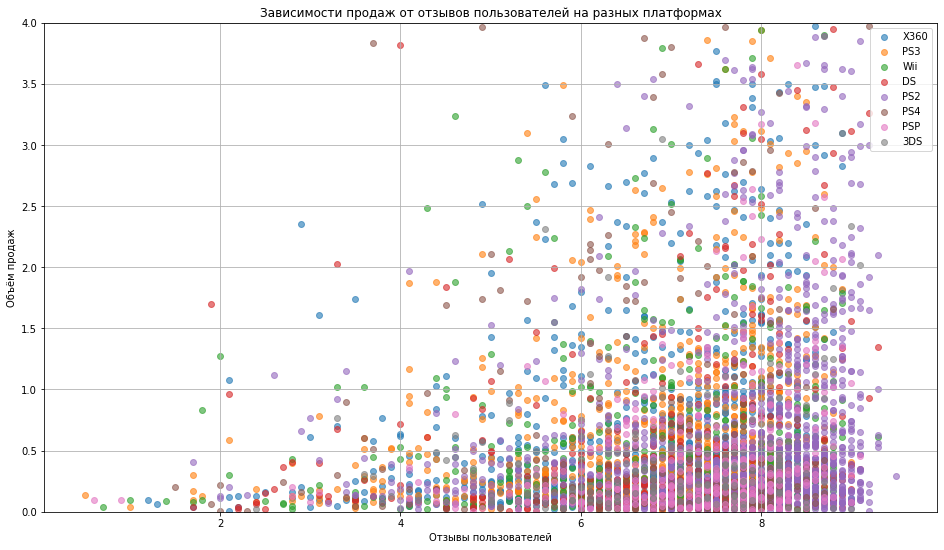

In [29]:
# Зависимости продаж от отзывов критиков

plt.figure(figsize=(16, 9))
plt.title('Зависимости продаж от отзывов критиков на разных платформах')
i=0
for platform in corr['platform']:
    xc = dict[platform]['critic_score'].to_list()
    yc = dict[platform]['sales'].to_list()
    plt.scatter(xc, yc, label=platform, alpha=0.6);
    i+=1 
plt.ylim(0,6)
plt.grid()
plt.xlabel('Отзывы критиков')    
plt.ylabel('Объём продаж')
plt.legend()
plt.show()

# Зависимости продаж от отзывов пользователей

plt.figure(figsize=(16, 9))
plt.title('Зависимости продаж от отзывов пользователей на разных платформах')
i=0
for platform in corr['platform']:
    xc = dict[platform]['user_score'].to_list()
    yc = dict[platform]['sales'].to_list()
    plt.scatter(xc, yc, label=platform, alpha=0.6);
    i+=1 
plt.ylim(0,4)
plt.grid()
plt.xlabel('Отзывы пользователей')    
plt.ylabel('Объём продаж')
plt.legend()
plt.show()

**Вывод:** Схожие зависимости наблюдаются на всех платформах: чем выше оценка - тем больше продаж.

### Распределение игр по жанрам

Выведем количество выпущенных игр по жанрам:

In [30]:
genre = data.groupby('genre')['name'].count().sort_values(ascending=False)
genre

genre
Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: name, dtype: int64

Выведем количество продаж по жанрам:

In [31]:
# Рассмотрим средние продажи
genre_sales = data.groupby('genre')['sales'].mean().sort_values(ascending=False)
genre_sales

genre
Platform        0.932173
Shooter         0.795503
Role-Playing    0.623872
Racing          0.583403
Sports          0.566980
Fighting        0.527126
Action          0.517711
Misc            0.458577
Simulation      0.446701
Puzzle          0.418224
Strategy        0.255095
Adventure       0.182341
Name: sales, dtype: float64

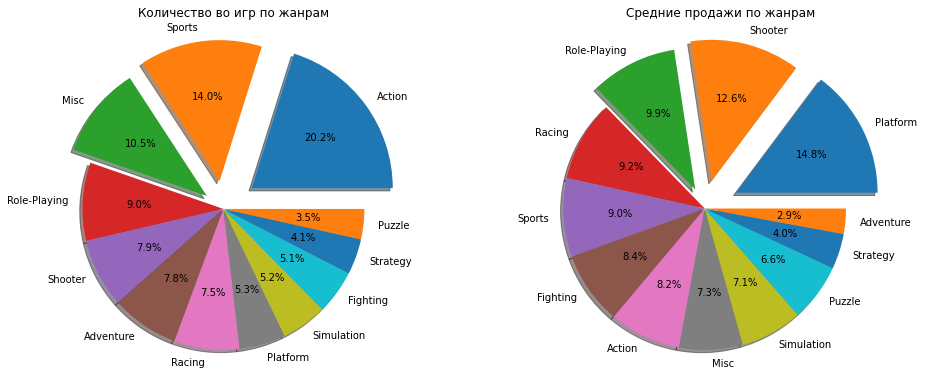

In [32]:
# Построим круговые диаграммы для наглядности

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
fig.autofmt_xdate();

labels1 = genre.index
sizes1 = genre.values

labels2 = genre_sales.index
sizes2 = genre_sales.values

explode = (0.25, 0.2, 0.15, 0,0,0,0,0,0,0,0,0)

ax1.set_title('Количество во игр по жанрам')
ax1.pie(sizes1, labels=labels1, autopct='%1.1f%%',
        shadow=True, explode=explode,startangle=0)  
ax1.axis('equal')

ax2.set_title('Средние продажи по жанрам')
ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%',
        shadow=True, explode=explode,startangle=0) 
ax2.axis('equal')

plt.show()

*Общее распределение игр по жанрам:*

ТОП-3:
- Action (**20,2%**)
- Sports (**14%**)
- Misc (**10,5%**)

Самые малочисленные: Puzzle (**3,5%**), Strategy (**4,1%**) и Fighting (**5,1%**).

*Распределение жанров по продажам:*

ТОП-3:
- Platform (**14,8%**)
- Shooter (**12,6%**)
- Role-Playing (**9,9%**)

Самые низкопродаваемые: Adventure (**2,9%**), Strategy (**4%**) и Puzzle (**6,6%**).

## Портрет пользователя по регионам

Для пользователя каждого региона (NA, EU, JP) определим:
- Самые популярные платформы (топ-5)
- Самые популярные жанры (топ-5)
- Влияние рейтинга ESRB на продажи в отдельном регионе

### Самые популярные платформы

In [33]:
# Запишем в словарь данные о продажах на топ-5 платформах в каждом регионе

pop_5_dict = {}
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    pop_5_dict[region] = data.groupby('platform')[region].sum().sort_values(ascending=False).head(5)
pop_5_dict

{'na_sales': platform
 X360    602.47
 PS2     583.84
 Wii     496.90
 PS3     393.49
 DS      382.40
 Name: na_sales, dtype: float64,
 'eu_sales': platform
 PS2     339.29
 PS3     330.29
 X360    270.76
 Wii     262.21
 PS      213.61
 Name: eu_sales, dtype: float64,
 'jp_sales': platform
 DS      175.57
 PS      139.82
 PS2     139.20
 SNES    116.55
 3DS     100.67
 Name: jp_sales, dtype: float64}

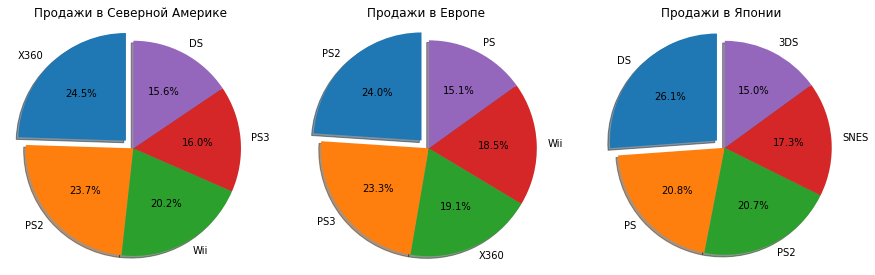

In [34]:
# Отобразим данные на графиках

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.autofmt_xdate()

i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']
reg = ['Северной Америке', 'Европе', 'Японии']
explode = (0.1, 0, 0, 0, 0)

for i in [0,1,2]:
    labels = pop_5_dict[region[i]].index
    sizes = pop_5_dict[region[i]].values
    ax = x[i]
    ax.set_title(f'Продажи в {reg[i]}')
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode,startangle=90) 
    ax.axis('equal')  

plt.show()

**Вывод:** Лидер продаж в каждом регионе свой: Америка - **X360**, Европа - **PS2** и Япония - **DS**. В Америке и Европе пользуются в основном одними и теми же платформами - X360, PS2, Wii, PS3, за исключением 5 места: в Америке больше любят DS, а в Европе PS. В Японии картина отличается: тут наиболее популярны платформы DS, SNES и 3DS.

Заметно, что платформа PS2 довольно популярна во всех регионах.

### Самые популярные жанры

In [35]:
# Алгоритм действий схож с предыдущим пунктом

pop_5g_dict = {}
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    pop_5g_dict[region] = data.groupby('genre')[region].sum().sort_values(ascending=False).head(5)
pop_5g_dict

{'na_sales': genre
 Action      879.01
 Sports      684.43
 Shooter     592.24
 Platform    445.50
 Misc        407.27
 Name: na_sales, dtype: float64,
 'eu_sales': genre
 Action     519.13
 Sports     376.79
 Shooter    317.34
 Racing     236.51
 Misc       212.74
 Name: eu_sales, dtype: float64,
 'jp_sales': genre
 Role-Playing    355.41
 Action          161.43
 Sports          135.54
 Platform        130.83
 Misc            108.11
 Name: jp_sales, dtype: float64}

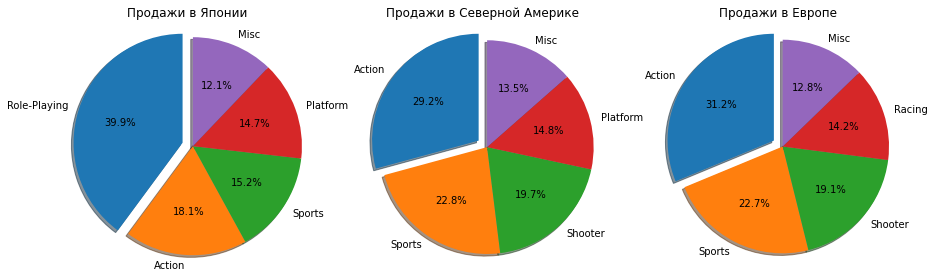

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.autofmt_xdate()

i = 0
x = [ax1, ax2, ax3]
region = ['jp_sales', 'na_sales', 'eu_sales']
reg = ['Японии', 'Северной Америке', 'Европе']
explode = (0.1, 0, 0, 0, 0)

for i in [0,1,2]:
    labels = pop_5g_dict[region[i]].index
    sizes = pop_5g_dict[region[i]].values
    ax = x[i]
    ax.set_title(f'Продажи в {reg[i]}')
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode,startangle=90) 
    ax.axis('equal')  

plt.show()

**Вывод:** ТОП-3 по жанрам в Америке и Европе одинаковый: это **Action**, **Sports** и **Shooter**. В Японии же сильно преобладает жанр **Role-Playing**, затем расположились **Action** и **Sports**.

Жанры Action и Sports довольно популярны во всех регионах.

### Влияние рейтинга ESRB на продажи 

In [39]:
# Для начала учтем игры без рейтинга
data['rating'] = data['rating'].fillna('No rating')

# Создадим сводную таблицу с рейтингом по регионам
esrb = data.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']]\
.sum().sort_values(by='na_sales', ascending=False).reset_index()

esrb

,rating,na_sales,eu_sales,jp_sales
0,E,1292.99,710.25,198.11
1,No rating,1240.68,613.30,841.93
2,T,759.75,427.03,151.40
3,M,748.48,483.97,64.24
4,E10+,353.32,188.52,40.20
5,K-A,2.56,0.27,1.46
6,EC,1.53,0.11,0.00
7,AO,1.26,0.61,0.00
8,RP,0.00,0.08,0.00


**Entertainment Software Rating Board (ESRB)** — негосударственная организация, основное направление деятельности — принятие и определение возрастных рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.

Существуют следующие рейтинги:

- **E** («Everyone») — «Для всех»
- **T** («Teen») — «Подросткам»
- **M** («Mature») — «Для взрослых»
- **E10+** («Everyone 10 and older») — «Для всех от 10 лет и старше»


- **EC** (**K-A** - в ранних версиях с 1994-1997 годы) («Early childhood») — «Для детей младшего возраста»
- **AO** («Adults Only 18+») — «Только для взрослых»
- **RP** («Rating Pending») — «Рейтинг ожидается»

**Вывод:** из сводной таблицы видно, что существует 4 основных рейтинга: «E»,«T»,«M» и «E10+» (остальные не очень популярны). Влияние рейтинга на продажи в разных регионах почти одинаково. На первом месте «E» и далее «T»,«M» и «E10+» (кроме Европы, где продажи с рейтингом «M» на 13% больше, чем с «T»). 

Наравне с количеством продаж игр с рейтингом «E» высоки продажи игр без рейтинга в Северной Америке и Европе, а в Японии вообще в 4 раза больше продаж игр без рейтинга, чем с рейтингом «E». Нужно понимать, что рейтинг ESRB выставляется не для всех проектов и не для всех регионов. Можно сделать вывод, что для Японии рейтинг ESRB слабо влияет на продажи.

## Проверка гипотез

Для проверки гипотез изпольуется **ttest** (статистический тест с использованием t-распределения - t-тест), т.к. он подходит для выборок любого размера, его принято применять в общих случаях.

### Гипотеза №1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [ ]:
XOne = data.query('platform == "XOne"')['user_score'].dropna().to_list()
PC = data.query('platform == "PC"')['user_score'].dropna().to_list()

print('Дисперсия Xbox One =', np.var(XOne))
print('-----------------------------------')
print('Дисперсия PC =', np.var(PC))

Значения дисперсий для двух платформ отличаются, поэтому задаём `equal_var=False`.

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые; альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различны.

In [ ]:
alpha = 0.05 #Задаём значение alpha 5% 

results = st.ttest_ind(XOne, PC, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

**Вывод:** нулевая гипотеза не может быть принята, принимаем альтернативную гипотезу: **средние пользовательские рейтинги платформ Xbox One и PC - различные**.

### Гипотеза №2. Средние пользовательские рейтинги жанров Action и Sports разные

In [ ]:
Action = data.query('genre == "Action"')['user_score'].dropna().to_list()
Sports = data.query('genre == "Sports"')['user_score'].dropna().to_list()

print('Дисперсия Action =', np.var(Action))
print('-----------------------------------')
print('Дисперсия Sports =', np.var(Sports))

Значения дисперсий для двух платформ отличаются, поэтому задаём `equal_var=False`.

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports равны; альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports разные.

In [ ]:
alpha = 0.05

results = st.ttest_ind(Action, Sports, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

**Вывод:** нулевая гипотеза не может быть отвергнута, принимаем нулевую гипотезу: **средние пользовательские рейтинги жанров Action и Sports равны**. Альтернативная гипотеза из задания - отвергнута.

## Общий вывод

**В ходе анализа выявлено:**

- Период до 1994 года характеризуется малой активностью. Хорошо видно, что резкий рост начался в 1994 году после него видеоигры начали выпускаться в огромных объемах. В 2010 наступает переломный момент и уже в 2012 релизы падают в 2 раза. До 2016 года релизы держатся примерно на одном уровне.


- Срок актуальности платформы - в среднем **11** лет. Можно выделить из списка платформ "PC", т.к. ПК как игровая платформа актуальна во все времена.


- По прогнозу на 2017 год можно выделить 2 самых перспективных платформы - **PS4** и **XOne**. WiiU и 3DS - тоже можно продолжать развивать, но в меньших объемах (середина срока жизни); платформа PC - актуальна всегда(но в малых объемах), нужно также поддерживать её развитие.


- Зависимость продаж от отзывов прямопропорцианальная - причем от отзывов критиков сильнее, чем от отзывов пользователей. Эта зависимость прослеживается на всех платформах.


- Общее распределение игр по жанрам - в тройку лидеров входят **Action (20,2%), Sports (14%) и Misc (10,5%)**. Самые малочисленные жанры: Puzzle (3,5%), Strategy (4,1%) и Fighting (5,1%). В продажах по жанрам в лидерах **Platform (14,8%), Shooter (12,6%) и Role-Playing (9,9%)**. Наименьшие продажи у Adventure (2,9%), Strategy (4%) и Puzzle (6,6%).


**Портрет пользователя каждого региона:**

- Лидеры продаж в регионах разные: **Америка - X360, Европа - PS2, а Япония - DS**. В Америке и Европе пользуются в основном одними и теми же платформами - X360, PS2, Wii, PS3. В Японии совсем другая картина: тут более популярны платформы DS, SNES и 3DS. Стоит отметить, что платформа PS2 очень популярна во всех регионах.


- В Америке и Европе ТОП-3 жанра: **Action, Sports и Shooter**. В Японии ситуация другая - там сильно лидирует жанр **Role-Playing**, также популярны Action и Sports. Выходит, что жанры Action и Sports популярны во всех трех регионах.


- Влияние рейтинга ESRB на продажи в США и Европе почти одинаково. На первом месте «E», далее «T», «M» и «E10+». Однако, в Японии рейтинг ESRB заметно слабее влияет на продажи: продажи игр без рейтинга в несколько раз больше, чем игр со всеми рейтингами вместе взятых.


**Проверены следующие гипотезы:**

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- Средние пользовательские рейтинги жанров Action и Sports разные.

Обе гипотезы не были приняты.

---

В ходе проекта отработан принцип работы с данными на основе данных до 2016 года. С помощью этого алгоритма можно прогнозировать актуальность платформ в будущем, скажем, для платформ 2027 года по данным до 2026 года.